In [1]:
import torch
import joblib
import pandas
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

# 데이터셋 분할

In [2]:
train_dataset = joblib.load('DataFrame/agv_dataframe_version_2.pkl')
X,y = train_dataset.drop(columns=['state','device_id','collection_date','collection_time','cumulative_operating_day']),train_dataset['state']
# X_test,y_test = X_test.reset_index(drop=True),y_test.reset_index(drop=True)
print(X.shape,y.shape)
y.value_counts(normalize=True)

(40427, 12) (40427,)


state
0    0.530091
2    0.201499
1    0.200139
3    0.068271
Name: proportion, dtype: float64

In [3]:
test_dataset = joblib.load('DataFrame/agv_test_17_18.pkl')
X_test,y_test = test_dataset.drop(columns=['state','device_id','collection_date','collection_time','cumulative_operating_day']),test_dataset['state']
X_test

,filenames,NTC,PM1.0,PM2.5,PM10,CT1,CT2,CT3,CT4,ex_temperature,ex_humidity,ex_illuminance
0,3.개방데이터\1.데이터\2.Validation\1.원천데이터\agv\17\agv1...,22.80,18.0,22.0,42.0,1.82,74.97,49.92,19.96,25.0,30.0,157.0
1,3.개방데이터\1.데이터\2.Validation\1.원천데이터\agv\17\agv1...,22.80,19.0,22.0,41.0,1.86,74.88,49.92,19.95,26.0,29.0,160.0
2,3.개방데이터\1.데이터\2.Validation\1.원천데이터\agv\17\agv1...,22.80,18.0,21.0,40.0,1.82,74.95,49.97,19.95,26.0,30.0,156.0
3,3.개방데이터\1.데이터\2.Validation\1.원천데이터\agv\17\agv1...,22.71,18.0,21.0,40.0,1.89,75.01,49.91,20.00,26.0,27.0,159.0
4,3.개방데이터\1.데이터\2.Validation\1.원천데이터\agv\17\agv1...,22.70,16.0,22.0,40.0,2.03,74.86,49.99,20.02,26.0,27.0,158.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4686,3.개방데이터\1.데이터\2.Validation\1.원천데이터\agv\18\agv1...,56.24,40.0,48.0,83.0,1.77,242.24,49.75,187.04,26.0,31.0,153.0
4687,3.개방데이터\1.데이터\2.Validation\1.원천데이터\agv\18\agv1...,56.20,41.0,48.0,83.0,2.05,246.04,49.76,191.15,25.0,34.0,155.0
4688,3.개방데이터\1.데이터\2.Validation\1.원천데이터\agv\18\agv1...,55.97,41.0,48.0,83.0,1.96,250.22,49.87,195.20,25.0,34.0,156.0
4689,3.개방데이터\1.데이터\2.Validation\1.원천데이터\agv\18\agv1...,55.90,42.0,48.0,83.0,1.84,254.90,49.72,199.78,25.0,28.0,152.0


# 파이토치 멀티 모달 데이터셋 

In [4]:
class MultimodalDataset(Dataset):
    """사용자 정의 멀티모달 데이터셋"""
    def __init__(self,X:pandas.DataFrame,y:pandas.Series):
        """필요한 데이터를 이곳에서 선언
        Parameter:
        X: 열화상 이미지와 센서데이터의 데이터 프레임
        y: 정답 데이터
        """
        self.X = X
        self.y = y
    def __getitem__(self, index):
        """열화상 이미지 [1,120,160]크기와 센서 데이터 11개의 칼럼 그리고 이에 해당하는 정답 데이터 반환"""
        image = torch.tensor(np.load(self.X.iloc[index]['filenames']),dtype=torch.float32).unsqueeze(0)
        sensor_features = self.X.drop(columns=['filenames'])
        sensor_features = torch.tensor(sensor_features.iloc[index].values,dtype=torch.float32)
        label = int(self.y.iloc[index]) # 나중에 학습하는데 있어서 느려지게하는 요인이면 데이터 프레임 자체에서 변경함함
        return image, sensor_features, label
    
    def __len__(self):
        return len(self.X)

train_dataset = MultimodalDataset(X,y)
test_dataset = MultimodalDataset(X_test,y_test)

train_image,train_sensor_features,train_label = train_dataset[0]
test_image,test_sensor_features,test_label = test_dataset[0]

print(len(train_dataset))
print(train_image.shape,train_sensor_features.shape,train_label)

print(len(test_dataset))
print(test_image.shape,test_sensor_features.shape,test_label)

40427
torch.Size([1, 120, 160]) torch.Size([11]) 0
4691
torch.Size([1, 120, 160]) torch.Size([11]) 0


# 멀티 모달 데이터 로더

In [5]:
train_dataloader = DataLoader(train_dataset,batch_size=16,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=16,shuffle=False)
print(len(train_dataloader),len(test_dataloader))

2527 294


# 멀티모달 AI 모델

In [6]:
class ViTFeatureExtractor(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth):
        super().__init__()
        # Transformer 설정
        self.vit = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=depth,
            batch_first=True
        )
        # Patch embedding: 채널을 1로 설정
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        # 포지셔널 임베딩
        num_patches = (img_dim_h // patch_size) * (img_dim_w // patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        # x: [batch_size, 1, img_dim_h, img_dim_w]
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)  # [batch_size, num_patches, embed_dim]
        x = patches + self.pos_embedding  # Positional embedding 추가
        x = self.vit(x, x)  # [batch_size, num_patches, embed_dim]
        return x.mean(dim=1)  # [batch_size, embed_dim]

class SoftLabelEncoder(nn.Module):
    def __init__(self, aux_input_dim, embed_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(aux_input_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, aux_data):
        return self.fc(aux_data)

class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

    def forward(self, query, key):
        attn_output, _ = self.attention(query, key, key)
        return attn_output

class ConditionClassifier(nn.Module):
    def __init__(self, img_dim_h,img_dim_w, patch_size, embed_dim, num_heads, depth, aux_input_dim, num_classes):
        super().__init__()
        self.vit = ViTFeatureExtractor(img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth)
        self.soft_label_encoder = SoftLabelEncoder(aux_input_dim, embed_dim)
        self.cross_attention = CrossAttention(embed_dim, num_heads)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, images, aux_data):
        # Feature extraction
        visual_features = self.vit(images)  # [batch_size, embed_dim]
        aux_features = self.soft_label_encoder(aux_data)  # [batch_size, embed_dim]

        # Cross attention
        visual_features = visual_features.unsqueeze(1)  # [batch_size, 1, embed_dim]
        aux_features = aux_features.unsqueeze(1)  # [batch_size, 1, embed_dim]
        integrated_features = self.cross_attention(visual_features, aux_features).squeeze(1)

        # Classification
        output = self.classifier(integrated_features)  # [batch_size, num_classes]
        return output
    
img_dim_h = 120  # 열화상 이미지 세로 크기
img_dim_w = 160  # 열화상 이미지 가로 크기
patch_size = 16
embed_dim = 256
num_heads = 8
depth = 6
aux_input_dim = 11  # 보조 데이터 차원 (예: 온도, 습도 등)
num_classes = 4  # 0:정상,1:관심,2:주의,3:위험
model = ConditionClassifier(img_dim_w, img_dim_h, patch_size, embed_dim, num_heads, depth, aux_input_dim, num_classes)

# 학습 및 평가 파이프라인

In [7]:
from tqdm.auto import tqdm
def train_step(model:torch.nn.Module,
               train_loader:torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               device:torch.device='cuda'):
    model.train()
    # 모델도 GPU 환경으로 보내기 (모델 학습시 GPU 학습 가속화)
    model = model.to(device)
    train_loss, train_acc = 0.0, 0.0
    for batch_images,batch_features,target in tqdm(train_loader):
        # GPU 상으로 데이터 보내기 (모델 학습시 GPU 학습 가속화)
        batch_images,batch_features,target = batch_images.to(device),batch_features.to(device),target.to(device)
        # 데이터 -> 모델 입력 
        y_pred = model(batch_images,batch_features)
        # 로스값 계산
        loss = loss_fn(y_pred,target)
        train_loss += loss.item()
        # 최적화 기울기 초기화
        optimizer.zero_grad()
        # 역전파 Loss Backward
        loss.backward()
        # Optimizer Step 가중치 업데이트
        optimizer.step()
        # 정확도 계산
        y_pred_class = torch.argmax(F.softmax(y_pred,dim=1),dim=1)
        train_acc += ((y_pred_class==target).sum().item()/len(y_pred))
    train_loss,train_acc = train_loss/len(train_loader), train_acc/len(train_loader)
    return train_loss,train_acc

def test_step(model:torch.nn.Module,
              test_loader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device:torch.device='cuda'):
    # 평가 모드
    model.eval()
    test_loss,test_acc = 0.0, 0.0
    # 추론 모드
    with torch.inference_mode():
        for batch_images,batch_features,target in tqdm(test_loader):
            # GPU 상으로 데이터 보내기 (모델 학습시 GPU 학습 가속화)
            batch_images,batch_features,target = batch_images.to(device),batch_features.to(device),target.to(device)
            
            # 데이터 -> 모델 입력 
            test_pred_logits = model(batch_images,batch_features)
            
            # 로스 계산
            loss = loss_fn(test_pred_logits,target)
            test_loss += loss.item()
            
            # 정확도 계산
            test_pred_class = torch.argmax(F.softmax(test_pred_logits,dim=1),dim=1)
            test_acc += ((test_pred_class==target).sum().item()/len(test_pred_logits))
    test_loss = test_loss / len(test_loader)
    test_acc = test_acc / len(test_loader)        
    return test_loss,test_acc

c:\Users\hyssk\anaconda3\envs\pytorch_cuda_11_8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 데이터 불균형으로 인해 Focal Loss & CrossEntropyLoss 비교

In [8]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
# loss_fn = CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr=0.0001)

In [9]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits, targets):
        ce_loss = self.ce_loss(logits, targets)
        pt = torch.exp(-ce_loss)  # 예측 확률
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

# train_dataloader = iter(train_dataloader)
# images,features,targets =next(train_dataloader)
# # 사용 예시
focal_loss = FocalLoss(alpha=0.25, gamma=2) # Focal Loss 파라미터 초기화
# logits = model(images,features) # 로짓 (모델에서 나온 값을 보통 로짓이라고 부름)
# loss = focal_loss(logits, targets) # 포칼로스
# loss_ce = loss_fn(logits,targets) # 크로스엔트로피 로스

# print("Focal Loss:", loss.item()) # 검출하기 쉬운 0(정상) 상태인거는 낮은 Loss값을
# print("CrossEntropyLoss:",loss_ce.item()) # CrossEntropy는 더 검출하기 쉽거나 그러한 개념이 없기 때문에 쉽게 검출 할 수 있는 것도 Focal Loss보다 로스값을 가짐
# print(logits)
# print(targets)

In [10]:
EPOCHS = 15
focal_loss = FocalLoss(alpha=0.25, gamma=2) # Focal Loss 파라미터 초기화
optimizer = Adam(model.parameters(),lr=0.00005)
results = {'train_acc':[],'train_loss':[],'test_acc':[],'test_loss':[]}
maximum_test_acc = 0

for epoch in range(1,EPOCHS+1,1):
    print(f"THIS IS {epoch} times")
    train_loss,train_acc = train_step(model,train_dataloader,focal_loss,optimizer)
    results['train_acc'].append(train_acc)
    results['train_loss'].append(train_loss)
    print(f'train_loss:{train_loss} | train_acc:{train_acc}')
    
    test_loss,test_acc = test_step(model,test_dataloader,focal_loss)
    results['test_acc'].append(test_acc)
    results['test_loss'].append(test_loss)
    
    print(f'test_loss:{test_loss} | test_acc:{test_acc}')
    
    if maximum_test_acc < test_acc:
        maximum_test_acc = test_acc
        torch.save(model,'17_18_AGV_Best_Model.pth')
        print(f'Best Model was saved. | test_acc : {test_acc}')
    else:
        pass
    
    print('-'*100)

THIS IS 1 times


  0%|          | 0/2527 [00:00<?, ?it/s]c:\Users\hyssk\anaconda3\envs\pytorch_cuda_11_8\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
100%|██████████| 2527/2527 [04:14<00:00,  9.91it/s]


train_loss:0.05164174052270358 | train_acc:0.812895726157499


100%|██████████| 294/294 [00:44<00:00,  6.58it/s]


test_loss:0.08191265476186084 | test_acc:0.8711734693877551
Best Model was saved. | test_acc : 0.8711734693877551
----------------------------------------------------------------------------------------------------
THIS IS 2 times


100%|██████████| 2527/2527 [07:21<00:00,  5.73it/s]


train_loss:0.026080789538843234 | train_acc:0.8763355757815592


100%|██████████| 294/294 [00:45<00:00,  6.48it/s]


test_loss:0.08973977729091881 | test_acc:0.8541666666666666
----------------------------------------------------------------------------------------------------
THIS IS 3 times


100%|██████████| 2527/2527 [06:18<00:00,  6.67it/s]


train_loss:0.021268858794822987 | train_acc:0.8829887218045113


100%|██████████| 294/294 [00:08<00:00, 35.37it/s]


test_loss:0.09905866481341895 | test_acc:0.8218537414965986
----------------------------------------------------------------------------------------------------
THIS IS 4 times


100%|██████████| 2527/2527 [04:32<00:00,  9.26it/s]


train_loss:0.020276268122461735 | train_acc:0.8898891966759003


100%|██████████| 294/294 [00:08<00:00, 35.73it/s]


test_loss:0.09932590659622605 | test_acc:0.8401360544217688
----------------------------------------------------------------------------------------------------
THIS IS 5 times


100%|██████████| 2527/2527 [06:08<00:00,  6.85it/s]


train_loss:0.018264043499176617 | train_acc:0.8916204986149584


100%|██████████| 294/294 [00:27<00:00, 10.61it/s]


test_loss:0.10428654894262816 | test_acc:0.8497023809523809
----------------------------------------------------------------------------------------------------
THIS IS 6 times


100%|██████████| 2527/2527 [04:36<00:00,  9.15it/s]


train_loss:0.017969680773391897 | train_acc:0.8946131776810448


100%|██████████| 294/294 [00:08<00:00, 33.70it/s]


test_loss:0.11042490736831623 | test_acc:0.8737244897959183
Best Model was saved. | test_acc : 0.8737244897959183
----------------------------------------------------------------------------------------------------
THIS IS 7 times


100%|██████████| 2527/2527 [05:16<00:00,  7.99it/s]


train_loss:0.016893037287083714 | train_acc:0.902206173328057


100%|██████████| 294/294 [00:44<00:00,  6.65it/s]


test_loss:0.11867092999601178 | test_acc:0.8660714285714286
----------------------------------------------------------------------------------------------------
THIS IS 8 times


100%|██████████| 2527/2527 [03:32<00:00, 11.91it/s]


train_loss:0.01585082394925156 | train_acc:0.903071824297586


100%|██████████| 294/294 [00:08<00:00, 33.92it/s]


test_loss:0.12516938712355016 | test_acc:0.8781887755102041
Best Model was saved. | test_acc : 0.8781887755102041
----------------------------------------------------------------------------------------------------
THIS IS 9 times


100%|██████████| 2527/2527 [04:00<00:00, 10.50it/s]


train_loss:0.015331639062933753 | train_acc:0.9085625247328848


100%|██████████| 294/294 [00:08<00:00, 35.91it/s]


test_loss:0.12920979819431755 | test_acc:0.8735119047619048
----------------------------------------------------------------------------------------------------
THIS IS 10 times


100%|██████████| 2527/2527 [05:07<00:00,  8.23it/s]


train_loss:0.015314938432715338 | train_acc:0.9071527502967947


100%|██████████| 294/294 [00:08<00:00, 34.43it/s]


test_loss:0.1427866667737697 | test_acc:0.875
----------------------------------------------------------------------------------------------------
THIS IS 11 times


 83%|████████▎ | 2109/2527 [05:35<01:06,  6.29it/s]


KeyboardInterrupt: 

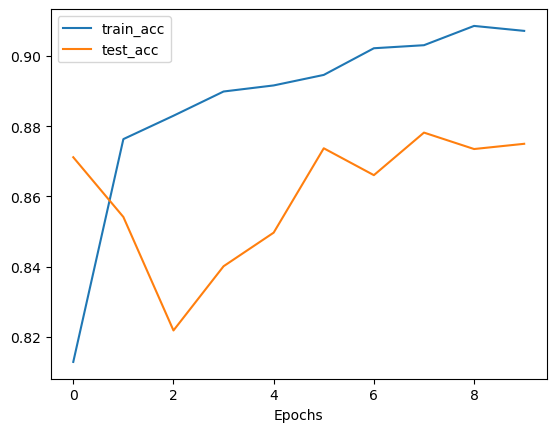

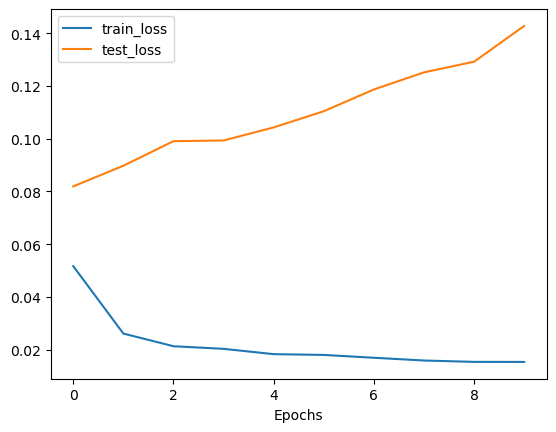

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(results['train_acc'],label='train_acc')
plt.plot(results['test_acc'],label='test_acc')
plt.legend()
plt.xlabel('Epochs')
plt.show()

plt.figure()
plt.plot(results['train_loss'],label='train_loss')
plt.plot(results['test_loss'],label='test_loss')
plt.legend()
plt.xlabel('Epochs')
plt.show()

In [15]:
Classifier = torch.load('17_18_AGV_Best_Model.pth')

C:\Users\hyssk\AppData\Local\Temp\ipykernel_25424\1981673491.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Classifier = torch.load('17_18_AGV_Best_Model.pth')


In [16]:
torch.save(Classifier.state_dict(), 'Parameters/17_18_AGV_Best_Model_Weights.pth')

tensor([0., 0., 0.,  ..., 3., 3., 3.], device='cuda:0')
tensor([0., 0., 0.,  ..., 3., 3., 3.], device='cuda:0')


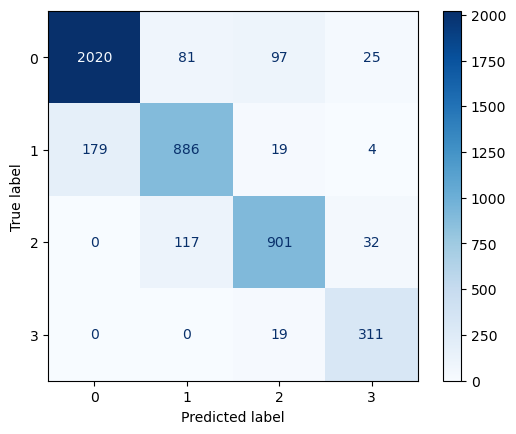

              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91      2223
         1.0       0.82      0.81      0.82      1088
         2.0       0.87      0.86      0.86      1050
         3.0       0.84      0.94      0.89       330

    accuracy                           0.88      4691
   macro avg       0.86      0.88      0.87      4691
weighted avg       0.88      0.88      0.88      4691



In [17]:
y_true = torch.tensor([]).to(device='cuda')
y_pred = torch.tensor([]).to(device='cuda')

with torch.inference_mode():
    model.eval()
    for images,features,targets in test_dataloader:
        images, features, targets = images.to('cuda'), features.to('cuda'), targets.to('cuda')
        predictions = torch.argmax(F.softmax(Classifier(images,features),dim=1),dim=1)
        y_pred = torch.cat((y_pred, predictions))
        y_true = torch.cat((y_true, targets))
print(y_pred)
print(y_true)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
y_true = y_true.cpu()
y_pred = y_pred.cpu()
cm = confusion_matrix(y_true,y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()
print(classification_report(y_true,y_pred))

In [ ]:
model_config = {"img_dim_h":120,
                "img_dim_w":160,
                "patch_size":16,
                "embed_dim":256,
                "num_heads":8,
                "depth":6,
                "aux_input_dim":11,
                "num_classes":4}